# Constants

In [ ]:
WORK_DIR_PATH = ".."
MODEL_NAME = "NAIS_BPR_AMusic_1e-3"

# Split
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
TRN_NEG_PER_POS_RATIO = 1
TST_NEG_PER_POS_RATIO = 100
NEG_PER_POS_RATIO = [TRN_NEG_PER_POS_RATIO, TRN_NEG_PER_POS_RATIO, TST_NEG_PER_POS_RATIO, TST_NEG_PER_POS_RATIO]
TRN_BATCH_SIZE = 128
TST_BATCH_SIZE = 5
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, TST_BATCH_SIZE, TST_BATCH_SIZE]
CURRICULUM = True
N_PHASES = 10
MAX_HIST = None

# Model
N_FACTORS = 32
SCORE_FN_TYPE = 'hadamard'
BETA = 0.5
DROPOUT = 0.2

# How to Learn
TASK_TYPE = 'bpr'
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-3

# Fit
N_EPOCHS = 1000
METRIC = 'ndcg'
INTERVAL = 10
PATIENCE = 10
DELTA = 1e-3

# Config

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

In [3]:
import json
import pandas as pd
import torch

In [ ]:
from NAIS import nais, loop
from MYUTILS import (
    ranking,
    utils,
)
from MYUTILS.config.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_K,
    SEED,
)

In [5]:
# Seed
utils.seed.reset(SEED)

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [6]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [7]:
# JSON lines 형식의 파일 열기
with open('./data/amusic.json', 'r', encoding='utf-8') as f:
    records = [json.loads(line) for line in f]

# reviewerID와 asin만 추출
filtered_records = [{'reviewerID': r['reviewerID'], 'asin': r['asin']} for r in records]

# DataFrame으로 변환
data = pd.DataFrame(filtered_records)

In [8]:
# Columns
kwargs = dict(
    col_user='reviewerID', 
    col_item='asin', 
)

data = utils.data.rename_columns(data, **kwargs)


# Label encoding
kwargs = dict(
    data=data, 
    col_user=DEFAULT_USER_COL, 
    col_item=DEFAULT_ITEM_COL,
)

data, user_label, item_label = utils.data.label_encoding(**kwargs)


# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [9]:
# data Description
utils.data.description(data)

number of user: 5541
number of item: 3568
total interaction: 64706
interaction density: 0.3273 %
max interaction of user: 578
top 10.0 % interaction of user: 20.0
mean interaction of user: 11
mean interaction of item: 18


In [10]:
kwargs = dict(
    data=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    curriculum=CURRICULUM,
    n_phases=N_PHASES,
)

dataloader = ranking.trn_val_tst.Module(**kwargs)

kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    seed=SEED,
    )

loaders, histories, interactions = dataloader.get(**kwargs)
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    score_fn_type=SCORE_FN_TYPE,
    beta=BETA,
    dropout=DROPOUT,
    trn_pos_per_user=histories,
)

model = nais.model.Module(**kwargs)

In [ ]:
kwargs = dict(
    model=model,
    trn_neg_per_pos_ratio=TRN_NEG_PER_POS_RATIO,
    task_type=TASK_TYPE,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_,
)

trainer = loop.trainer.Module(**kwargs)

# Train

In [ ]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    metric=METRIC,
    interval=INTERVAL,
    patience=PATIENCE,
    delta=DELTA,
)

history = trainer.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 521
LEAVE ONE OUT BEST SCORE: 0.4380


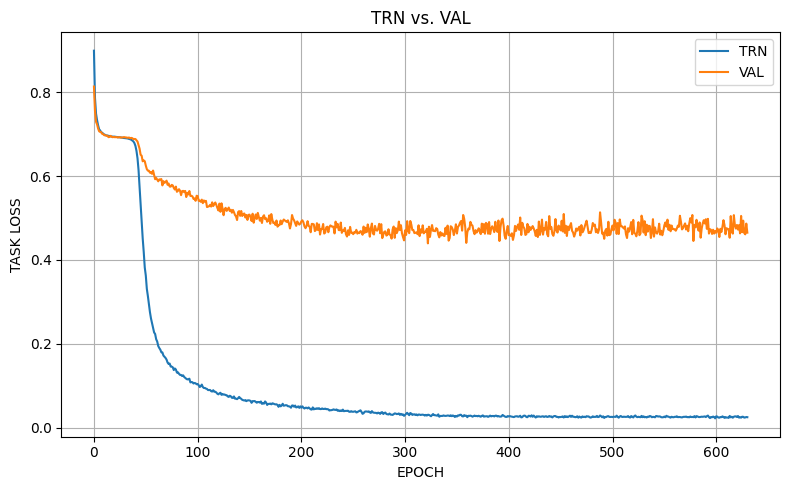

In [14]:
utils.visualizer.plot_loss(history, 'TASK LOSS')

# Test

In [15]:
TRUE_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_LABEL_COL]
PRED_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_PREDICTION_COL]

In [ ]:
kwargs = dict(
    model=model,
    tst_loader=tst_loader,
)

result = loop.predictor.predict(**kwargs)

TST: 100%|██████████| 1226/1226 [00:04<00:00, 253.64it/s]


In [17]:
top_k_list = [5, 10, 15, 20, 50, 100]
eval_list = []

for TOP_K in top_k_list:
    kwargs = dict(
        rating_true=result[TRUE_COL_LIST],
        rating_pred=result[PRED_COL_LIST],
        k=TOP_K,
    )
    eval = ranking.metrics.eval_top_k(**kwargs)
    eval_list.append(eval)

eval_df = pd.DataFrame(eval_list)
eval_df

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.578817,0.130681,0.512995,0.348625,0.404742
1,10,0.704873,0.084734,0.642739,0.369273,0.447954
2,15,0.773496,0.064064,0.718094,0.376789,0.469122
3,20,0.814520,0.051554,0.763567,0.380085,0.480699
4,50,0.935604,0.025022,0.900862,0.386092,0.510819
5,100,0.998508,0.013869,0.979091,0.387804,0.525083


# Save

In [ ]:
PATH = f'./checkpoints/{MODEL_NAME}.pth'

kwargs = dict(
    model=model, 
    path=PATH,
)

utils.checkpoint.save(**kwargs)